In [1]:
from __future__ import print_function, division

import numpy as np
from tensorflow.keras.datasets import mnist, fashion_mnist, cifar10
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import initializers, regularizers, constraints
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.layers import Input, Reshape, BatchNormalization, Concatenate, multiply
from tensorflow.keras.layers import Dense, Flatten, LeakyReLU, Dropout, Embedding, Activation, concatenate
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.train import Checkpoint, CheckpointManager

import json
import matplotlib.pyplot as plt
from numpy.random import randn, randint
from skimage.transform import resize
import time
import random
import os
import tensorflow as tf
from sklearn.model_selection import KFold
from tensorboard.plugins.hparams import api as hp
from scipy.linalg import sqrtm

In [2]:
from tensorflow.compat.v1 import ConfigProto, InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
def random_list(num_samples):
    randomlist = []

    for i in range(num_samples):
        n = random.randint(0,9)
        randomlist.append(n)
    return randomlist


# scale an array of images to a new size
def scale_images(images, new_shape):
    images_list = list()
    for image in images:
        # resize with nearest neighbor interpolation
        new_image = resize(image, new_shape, 0)
        # store
        images_list.append(new_image)
    return np.asarray(images_list)

In [ ]:
def set_checkpoint(generator,discriminator, cGan,max_to_keep=10):
    
    checkpoint_path = 'C:/Users/simoc/Documents/checkpoint_aml'
    ckpt = Checkpoint( generator= generator, discriminator = discriminator, cGan= cGan)
    ckpt_manager = CheckpointManager(ckpt, checkpoint_path, max_to_keep=max_to_keep)
    
    # if a checkpoint exists, restore the latest checkpoint.
    if ckpt_manager.latest_checkpoint:
        ckpt.restore(ckpt_manager.latest_checkpoint)
        print('Latest checkpoint restored!!')

    return ckpt, ckpt_manager

## MODEL EVALUATION- FRECHET JOINT DISTANCE

In [ ]:
def get_alpha(act, one_hot_cond):
    
    act_norm = np.mean(np.linalg.norm(act, axis=1))
    cond_norm = np.mean(np.linalg.norm(one_hot_cond, axis=1))
    
    return act_norm / cond_norm



def FJD(inception, images1, images2, class_labels, alpha=None):
    
    # calculate activations
    act1 = inception.predict(images1)
    act2 = inception.predict(images2)
    
    sampled_labels = np.array(class_labels).reshape(-1, 1)
    sampled_labels_categorical = to_categorical(sampled_labels)

    if alpha == None:
        alpha = get_alpha(act2, sampled_labels_categorical)
    
    joint_embed_1 = np.concatenate([act1, alpha*sampled_labels_categorical], axis=1)
    joint_embed_2 = np.concatenate( [act2, alpha*sampled_labels_categorical], axis=1)
    

    mu1, sigma1 = np.mean(joint_embed_1, axis=0), np.cov(joint_embed_1, rowvar=False)
    mu2, sigma2 = np.mean(joint_embed_2, axis=0), np.cov(joint_embed_2, rowvar=False)

    # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)

    return fid



def evaluate_FJD(generator, X_test, inception, class_labels, alpha = None ):
    
    X_test = X_test[:50]
    
    noise = generate_latent_points(50)
    
    sampled_labels = np.array(class_labels).reshape(-1, 1)
    sampled_labels_categorical = to_categorical(sampled_labels)
    X_fake = generator.predict([noise, sampled_labels_categorical])
    
   # X_fake = X_train.astype('float32')
    #X_test = X_test.astype('float32')
    
    X_fake = scale_images(X_fake,(299,299,3))
    X_test = scale_images(X_test,(299,299,3))
    
    X_fake = preprocess_input(X_fake)
    X_test = preprocess_input(X_test)
    
    fjd = FJD(inception, X_fake, X_test, class_labels, alpha)
    
    return fjd

In [ ]:
def FID(model, images1, images2):
    
    # calculate activations
    act1 = model.predict(images1)
    act2 = model.predict(images2) 

    #calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    
    # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid


In [ ]:
def load_dataset(num_classes=10, dataset='mnist'):
    
    if dataset == 'mnist':
        (X_train, y_train), (X_test, y_test) = mnist.load_data()
    elif dataset == 'fashion_mnist':
        (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
    elif dataset == 'cifar10':
        (X_train, y_train), (X_test, y_test) = cifar10.load_data()
    else:
        raise ValueError('Dataset Not Found!')

    
    X_train = np.expand_dims(X_train, axis = 3)
    X_test = np.expand_dims(X_test, axis = 3)
    
    print('X_train, y_train shape:', X_train.shape, y_train.shape, 
          '\nX_test shape, y_test shape:', X_test.shape, y_test.shape)
    
    # convert class vectors to binary class matrices 
    y_train = to_categorical(y_train, num_classes=num_classes)
    y_test = to_categorical(y_test, num_classes=num_classes)
    
    # the generator is using tanh activation in the last layer, for which we need to preprocess 
    # the image data into the range between -1 and 1.

    X_train = np.float32(X_train)

    # clip in range [-1, 1] 
    X_train = (X_train / 127.5)-1


    X_test = np.float32(X_test)
    # clip in range [-1, 1] 
    X_test = (X_test/ 127.5) -1


    print('y_train reshape:', y_train.shape)
    print('y_test reshape:', y_test.shape)
    return X_train, y_train,  X_test, y_test



def plot_loss(d_loss,g_loss, dim):
    plt.close()
    plt.figure(figsize=dim)
    plt.plot(d_loss)
    plt.plot(g_loss)
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Iteration')
    plt.legend(['Discriminator', 'Adversarial'], loc='upper right')
    plt.show()

def evaluate(generator, X_test, inception, it ):
    
    np.random.shuffle(X_test)
    X_test = X_test[:50]
    
    noise = generate_latent_points(50)
    sampled_labels = np.array(class_labels).reshape(-1, 1)
    sampled_labels_categorical = to_categorical(sampled_labels)
    X_fake = generator.predict([noise, sampled_labels_categorical])

    X_fake = scale_images(X_fake,(299,299,3))
    X_test = scale_images(X_test,(299,299,3))
    
    X_fake = preprocess_input(X_fake)
    X_test = preprocess_input(X_test)
    
    fid = FID(inception, X_fake, X_test)
    return fid

def plot_fjd(fjd,it):
    
    plt.plot(it,fjd)
    plt.title('Frechet Joint Distance')
    plt.ylabel('FJD')
    plt.xlabel('Iteration')
    plt.grid()
    plt.show()

def generate_latent_points(n_samples, latent_dim=100):
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape((n_samples, latent_dim)) 	
    return x_input


#plot result

def plot_real_samples(X_train,num_samples, class_labels, title="", r=5, c=10):
    
    fig=plt.figure(figsize=(9,7), tight_layout=True)
    
    sampled_labels = np.array(class_labels).reshape(-1, 1)
    sampled_labels_categorical = to_categorical(sampled_labels)
    n=1
    for k in range(num_samples):
        plt.subplot(r, c, n, xticks=[], yticks=[])
        aux = np.squeeze(X_train[k])
        plt.imshow(((aux + 1)* 127).astype(np.uint8),cmap='gray')
        n+=1

    fig.suptitle(title,y=1.01)
    plt.show()

def plot_result(generator, class_labels, title="", num_samples=25, r=5, c=10, fashion_mnist=False):
        
        noise = generate_latent_points(num_samples)
        
        sampled_labels = np.array(class_labels).reshape(-1, 1)
        sampled_labels_categorical = to_categorical(sampled_labels)
        x_fake = generator.predict([noise, sampled_labels_categorical])

        plt.figure(figsize=(10,7), tight_layout=True)
        n=1
        for i in range(num_samples):
            plt.subplot(r, c, n, xticks=[], yticks=[])
            plt.imshow(x_fake[i, :, :, 0], cmap='gray')
            if fashion_mnist == True:
                class_labels_fashion = zip( class_labels, ['T-shirt/top','Trouser','Pullover','Dress', 'Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']*5)
                class_labels_fashion = list(class_labels_fashion)
                plt.title('{}'.format(class_labels_fashion[i][1] ))
            else:
                plt.title("Digit: %d" % sampled_labels[i])
            n+=1      
        plt.suptitle(title, y=1.01)

## Conditional GANs model

In [ ]:
class CGAN:
    
    def __init__(self, img_width, img_height, n_channels, n_classes):
        
        self.img_width = img_width
        self.img_height = img_height
        self.n_channels = n_channels
        self.img_shape = (self.img_width, self.img_height, self.n_channels)
        self.n_classes = n_classes
        self.latent_dim = 100

        self.optimizer = Adam(lr=0.001)

    
    def build_discriminator_model(self, input_shape=(28,28,1)):

        rn = initializers.RandomNormal(stddev=0.02)
        
        model_input = Input(shape= input_shape, name='discriminator_input')

        x = model_input

        labels = Input(shape=(self.n_classes,))
        labels_embedded = Flatten()(Embedding(self.n_classes, self.latent_dim)(labels))
        labels_embedded = Dense(self.img_width * self.img_width)(labels)
        labels_embedded = Reshape((self.img_width, self.img_height, self.n_channels))(labels_embedded)

        x = concatenate([x, labels_embedded])


        x = Conv2D(filters=56, kernel_size=(5,5), strides=2, padding='same',kernel_initializer=rn)(x)
        x = LeakyReLU(alpha=0.2)(x)

        x = Conv2D(filters=112, kernel_size=(5,5), strides=2, padding='same',kernel_initializer=rn)(x)
        x = LeakyReLU(alpha=0.2)(x)

        x = Conv2D(filters=224, kernel_size=5, strides=2, padding='same', kernel_initializer=rn)(x)
        x = LeakyReLU(alpha=0.2)(x)


        x = Flatten()(x)
        x = Dense(1)(x)
        x = Activation('sigmoid')(x)
        # model_input is conditioned by labels
        discriminator = Model(inputs=[model_input, labels], outputs=x, name='discriminator')

        return discriminator

    def build_generator(self):
        
        rn = initializers.RandomNormal(stddev=0.02)

        inputs = Input(shape=(self.latent_dim,), name='z_input')
        labels = Input(shape=(self.n_classes,), name='class_labels')
        

        x = concatenate([inputs, labels], axis=1)

        x = Dense(7*7*112)(x)
        x = Reshape((7, 7, 112))(x)
        x = BatchNormalization()(x)
        x = Activation(LeakyReLU(0.2))(x)
        
        x = Conv2DTranspose(filters=56, kernel_size=(5,5), strides=(2,2), padding='same',  kernel_initializer=rn)(x)
        x = BatchNormalization()(x)
        x = Activation(LeakyReLU(0.2))(x)
        
        x = Conv2DTranspose(filters=64, kernel_size=(5,5), strides=(2,2), padding='same', kernel_initializer=rn)(x)
        x = BatchNormalization()(x)
        x = Activation(LeakyReLU(0.2))(x)
        x = Conv2DTranspose(filters=1, kernel_size=(5,5), strides=(1,1), padding='same',kernel_initializer=rn)(x)

        x = Activation('tanh')(x)
        # input is conditioned by labels
        generator = Model(inputs=[inputs, labels], outputs=x, name='generator')
        return generator

    def cgan(self, generator, discriminator):
         # Build and compile the discriminator
        discriminator.compile(loss=['binary_crossentropy'],
                                   optimizer=Adam(lr=0.0002, beta_1=0.5),
                                   metrics=['binary_accuracy'])
        discriminator.trainable = False
        #discriminator.summary()

        #generator.summary()

        noise = Input(shape=(self.latent_dim, ))
        label = Input(shape=(self.n_classes,))
        img = generator([noise, label])

        # during generator updating,  the discriminator is fixed (will not be updated).
       

        # The discriminator takes generated image and label as input and determines its validity
        validity = discriminator([img, label])

        cgan_model = Model(inputs=[noise, label], outputs=validity)
        cgan_model.compile(loss=['binary_crossentropy'],
                                optimizer=Adam(lr=0.0002, beta_1=0.5),
                                metrics=['binary_accuracy'])
        
        plot_model(cgan_model, show_shapes=True, to_file='cgan-adversarial_model.png')
        plot_model(generator, show_shapes=True, to_file='cgan-generator_model.png')
        plot_model(discriminator, show_shapes=True, to_file='cgan-discriminator.png')

        return cgan_model



    def train(self, x_train, x_test, y_train, generator, discriminator, cGAN, 
              class_labels, iterations=100000, check_point_interval=25000, batch_size=32, 
              sample_interval=300, k=1, fashion_mnist=False, save_model=False, verbose=True):
        
        # Adversarial ground truths
        real = np.ones(shape=(batch_size, 1))
        fake = np.zeros(shape=(batch_size, 1))
        
        inception = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))

        # Label smoothing (label from 1 to 0.9: it helps during training)
        smooth=0.1

        init_time = time.time()

        d_loss = []
        g_loss = []

        tot_time = 0
        time_tmp = 0
        x_fjd = []
        fjd_list = []
        ckpt, ckpt_manager = set_checkpoint(generator=generator,discriminator=discriminator, cGan=cGAN)
        
        for it in range(iterations):
            start = time.time()
            
            for _ in range(k):
                
                discriminator.trainable = True
                # Select a random half batch of images
                idx = np.random.randint(0, x_train.shape[0], size=batch_size)
                imgs, labels = x_train[idx], y_train[idx]


                # Condition on labels (random one-hot labels)
                fake_labels = np.eye(self.n_classes)[np.random.choice(self.n_classes, batch_size)]
                
                # Generate a half batch of new images
                # Generate sample noise for generator input
                z = generate_latent_points(n_samples= batch_size)
            
                # we can use labels instead of fake_labels; because it is fake for noise
                x_fake = generator.predict([z, labels])

                # --------------------- Train the Discriminator ---------------------
                # Update the Discriminator by ascending its stochastic gradient
                d_loss_real = discriminator.train_on_batch([imgs, labels], real*(1-smooth))
                d_loss_fake = discriminator.train_on_batch([x_fake, fake_labels], fake)
                
                # Discriminator loss
                d_loss_batch = 0.5*np.add(d_loss_fake, d_loss_real)
                discriminator.trainable = False

            #  --------------------- Train the Generator ---------------------

            z = generate_latent_points(n_samples= batch_size)
            fake_labels = np.eye(self.n_classes)[np.random.choice(self.n_classes, batch_size)]
            # Train the generator
            g_loss_batch= cGAN.train_on_batch([z, fake_labels], real)

            d_loss.append(d_loss_batch[0])
            g_loss.append(g_loss_batch[0])

            end= time.time()
            time_tmp += ( end-start )
            # If at save interval => save generated image samples
            if it % sample_interval == 0:
                
                fjd= evaluate_FJD(generator, x_test, inception, class_labels)
                fjd_list.append(fjd)
                print('\n------------------------------------------------------------- \n')
                print('\nIteration {0}/{1} :  d_loss={2}, g_loss={3}, FJD={4}\n'.format(it , iterations, d_loss[-1], g_loss[-1], fjd))
               
                
                hours, rem = divmod(time_tmp, 3600)
                minutes, seconds = divmod(rem, 60)
                print("\nExecution Time for {} terations: {:0>2}:{:0>2}:{:05.2f}\n".format(sample_interval, int(hours),int(minutes),seconds),end="\n\n")
                print('\n-------------------------------------------------------------\n')                                                                         
                
                tot_time+= (time_tmp)
                
                hours_, rem_ = divmod(tot_time, 3600)
                minutes_, seconds_ = divmod(rem_, 60)
                print("\n Total time  for {} terations: {:0>2}:{:0>2}:{:05.2f}\n".format(it, int(hours_),int(minutes_),seconds_),end="\n\n")
                print('\n-------------------------------------------------------------\n')                                                                         
                
                
                if verbose == True:
                    self.plot_generated_images(generator=generator, class_labels=class_labels, tot_time=tot_time, 
                                           it=it, fashion_mnist=fashion_mnist)
                    plot_loss(d_loss, g_loss, (6,4)) 
                    
                    x_fjd.append(it)
                    
                    plot_fjd(fjd_list,x_fjd)
                time_tmp = 0
            
            if save_model == True:
                if it % check_point_interval == 0:
                    ckpt_save_path = ckpt_manager.save()
                    print('Saving checkpoint for iteration {} at {}'.format(it,ckpt_save_path))
                                                                                
                
        if save_model == True:
            print('saving model ...')
            generator.save('model/generator')
            disctiminator.save('model/discriminator')
            cGAN.save('model/cGAN')
        
        return d_loss, g_loss, fjd_list, tot_time         

    def plot_generated_images(self, generator, class_labels, tot_time, it, fashion_mnist, r=5, c=10):
        
        num_samples = len(class_labels)
        noise = generate_latent_points(num_samples)
        
        sampled_labels = np.array(class_labels).reshape(-1, 1)
        sampled_labels_categorical = to_categorical(sampled_labels)
        x_fake = generator.predict([noise, sampled_labels_categorical])

        plt.figure(figsize=(13,9))

        n=1
        for i in range(num_samples):
            plt.subplot(r, c, n, xticks=[], yticks=[])
            plt.imshow(x_fake[i, :, :, 0], cmap='gray')
            if fashion_mnist == True:
                class_labels_fashion = zip( class_labels, ['T-shirt/top','Trouser','Pullover','Dress', 'Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']*5)
                class_labels_fashion = list(class_labels_fashion)
                plt.title('{}'.format(class_labels_fashion[i][1] ))
            else:
                plt.title("Digit: %d" % sampled_labels[i])
            n+=1      
        
        hours, rem = divmod(tot_time, 3600)
        minutes, seconds = divmod(rem, 60)
                
        plt.suptitle("Iteration {}: \n Execution Time: {:0>2}:{:0>2}:{:05.2f}".format(it, int(hours),
                                                                                      int(minutes),seconds), y=0.97)

        plt.show()
    
    
    


In [ ]:
def crossvalidation(X_train, y_train, batch_size_list,  class_labels, save_name='crossvalidation_result.txt', iterations=100000, fashion_mnist=False):
        
    kfold = KFold(n_splits = 2)
        
    fid_score= []
    
    c = True
    for batch in batch_size_list:
            
        fid_tmp = []    
        fold=0
        
        for train_index, test_index in kfold.split(X_train):
                
            print('\n------------------Batch_size {0}-Fold {1}----------------\n'.format(batch,fold))
            fold+=1
            if c ==True:
                c=False
                continue
                
            Xtr=X_train[train_index]
            Xte=X_train[test_index]
            Xte = np.repeat(Xte, 3, 3)
            

            Yte=y_train[test_index]
            Ytr=y_train[train_index]
                
            cgan = CGAN(img_w, img_h, num_channels, num_classes)
            discriminator = cgan.build_discriminator_model()
            generator = cgan.build_generator()
            cGAN= cgan.cgan(generator, discriminator)
                
            d_loss, g_loss, fjd_list, tot_time = cgan.train(x_train=Xtr, x_test=Xte, y_train=Ytr, generator=generator, 
                                                            discriminator=discriminator, cGAN=cGAN, 
                                                            class_labels=class_labels,iterations=iterations, 
                                                            check_point_interval=25000, 
                                                            batch_size=batch, sample_interval=500, 
                                                            k=1, fashion_mnist=fashion_mnist, verbose=True)
                
                
            cgan.plot_generated_images(generator=generator, class_labels=class_labels, tot_time=tot_time, 
                                        it=iterations, fashion_mnist=fashion_mnist)
                
            plot_loss(d_loss, g_loss, (6,4)) 
            time_tmp = 0
                
                
            fid_tmp.append( fjd_list[-1])
                
            

        fid_score.append(np.mean(fid_tmp))
            
        with open(save_name, 'w') as f:
            f.write(json.dumps(list( zip(batch_size_list, fid_score))))
                
    return fid_score
            
            
        

## Crossvalidation FASHION MNIST


### Class Labels Fashion Mnist:

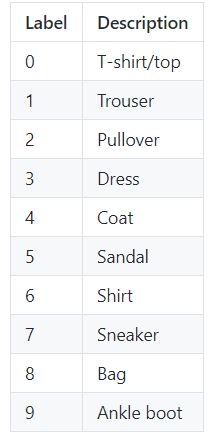

In [ ]:
# Load the dataset and define the condition of cGAN model
X_train, y_train, X_test, y_test = load_dataset(dataset='fashion_mnist')
X_test = np.repeat(X_test, 3, 3)
print('ddd', X_test.shape)
num_classes = 10
class_labels = np.array([0,1,2,3,4,5,6,7,8,9] * 5)

In [ ]:
import os
physical_devices = tf.config.list_physical_devices('GPU') 
print(physical_devices)
   
img_w, img_h, num_channels = X_train[0].shape



print('\n\n---------------START CROSSVALIDATION----------------------------------\n\n')

start = time.time()

batch_size_list=[2, 32, 64, 128]

fid_score = crossvalidation(X_train=X_train, y_train=y_train, 
                            batch_size_list=batch_size_list,  
                            class_labels=class_labels, iterations=100000, 
                            save_name='crossvalidation_result_fashion_mnist_it_100000_3.txt', 
                            fashion_mnist=True)

end= time.time()

hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)

print('\n\n---------------END CROSSVALIDATION----------------------------------\n\n')



print("Total Execution Time: {:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes), seconds) )



In [ ]:
# LOAD RESULT CROSSVALIDATION PREVIOUSLY SAVED ON crossvalidation.txt

fjd = []
batch = []
with open('crossvalidation_result.txt', 'r') as f:
    results = json.loads(f.read())
    for r in results:
        batch.append(r[0])
        fjd.append(r[1])


In [ ]:
# PLOT RESULT CROSSVALIDATION


def auto_label(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        plt.annotate('{:.1f}'.format(height),
                     xy=(rect.get_x() + rect.get_width() / 2, height),
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom',fontsize=20)

#plot resuls in a histogram
plt.figure(figsize=(15,10))

for b, f in zip(batch, fjd):
    curr_rects= plt.bar(b, f, width=15, label='batch size = '+str(b))
    auto_label(curr_rects)
plt.legend(fontsize=16)
plt.title('Kfold-Crossvalidation-100.000 iterations', size=20)
plt.ylabel('Frèchet Joint Distance (FJD)',size=20)
plt.xlabel('Batch Size',size=20)
plt.margins(x=0.4,y=0.3)
plt.xticks(batch)
plt.grid()

In [ ]:
#train model

img_w, img_h, num_channels = X_train[0].shape
cgan = CGAN(img_w, img_h, num_channels, num_classes)
discriminator = cgan.build_discriminator_model()
generator = cgan.build_generator()
cGAN= cgan.cgan(generator, discriminator)


img_w, img_h, num_channels = X_train[0].shape

best_batch_size_idx = np.argmin(fjd)

print('Best batch_size-FID: ', fjd[best_batch_size_idx], '-', batch[best_batch_size_idx])
best_batch_size = batch_size_list[best_batch_size_idx]

d_loss, g_loss, fid_list, tot_time = cgan.train(X_train, X_test, y_train, generator, discriminator, cGAN, class_labels, iterations=100000, batch_size=best_batch_size, sample_interval=500, k=1, save_model=True, verbose =True)